## Replicating the results of Becker et al. 2011
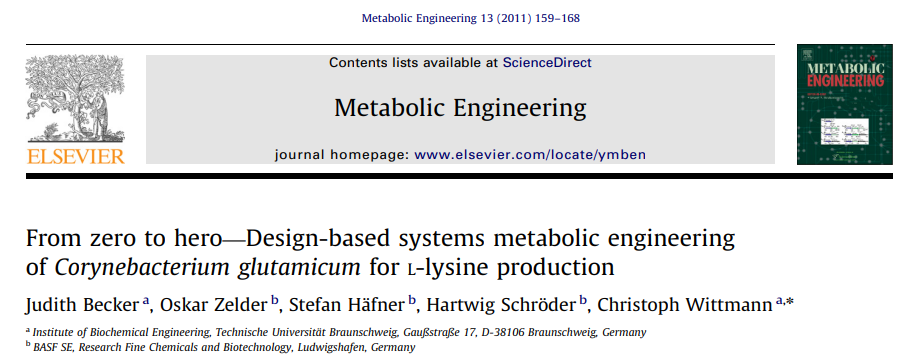

Author: 
`Haroun Bensaadi`

The issue with the model "iCGB21FR.xml" is that its authors have named the genes in the following format **"lcl_{locus}_prot_{protein_id}"**. An exemple name of the genes from the model would look like this: lcl_NC_006958_1_prot_WP_003859586_1_2138

In which **"NC_006958"** is the locus represent the complete sequence of _Corynebacterium glutamicum_ ATCC 13032, and **WP_XXXXXXXXX** represent the protein_id of its genes.


**This results in adding an extra step of finding the gene name for the concerned protein ids.**

In [8]:
%run gene_annotation.ipynb

from colorama import init, Fore, Style
from cobra import Model, Reaction
from cobra.io import read_sbml_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def printText(text1, color1=Fore.WHITE, text2="", color2=Fore.WHITE, style=Style.BRIGHT):
    print(style + color1 + text1 + color2 + text2 + Style.RESET_ALL)

model = read_sbml_model('Files/iCGB21FR_updated.xml')

### Annotating the genes

In [4]:
%run gene_annotation.ipynb
genes_to_find = ["lysC", "pck", "dapB", "lysA", "hom", "pyc", "icd", "fbp", "tkt", "ddh"]
found_matches = findGenes(genes_to_find, model)

genes_map = printReport(found_matches)
genes_map

Total number of unique genes in the model is: 786 genes

RefSeq data from  C. glutamicum ATCC 13032 is already stored locally: 786 genes

MATCH: dapB ->

    ● WP_011014794 [4-hydroxy-tetrahydrodipicolinate reductase]

MATCH: lysA ->

    ● WP_011014180 [diaminopimelate decarboxylase]

MATCH: tkt ->

    ● WP_011014456 [transketolase]

KEGG data from other C. glutamicum strains is already stored locally: 10 strains

    Homologous genes for hom: 6 results
    Homologous genes for lysC: 4 results
    Homologous genes for ddh: 2 results
    Homologous genes for icd: 3 results
    Homologous genes for pck: 3 results
    Homologous genes for pyc: 2 results
    Homologous genes for fbp: 12 results

Fetching AA sequence for the homologous genes: 

    hom (cgb:cg1337): MTSASAPSFNPGKGPGSAVGIALLG...
    Hom (cgu:WA5_1136): MTSASAPSFNPGKGPGSAVGIALLG...
    hom (cgf:CGUA_05360): MTATAQTSFNPGKGVGQPVGVAVLG...
    obgE (rho:RHOM_07550): MFADRATIIIKSGKGGDGHVSFRRE...
    obg (mhom:MLBD4_00730): MKFID

{'dapB': 'lcl_NC_006958_1_prot_WP_011014794_1_1871',
 'lysA': 'lcl_NC_006958_1_prot_WP_011014180_1_1145',
 'tkt': 'lcl_NC_006958_1_prot_WP_011014456_1_1529',
 'lysC': 'lcl_NC_006958_1_prot_WP_003855724_1_250',
 'pck': 'lcl_NC_006958_1_prot_WP_011015446_1_2735',
 'hom': 'lcl_NC_006958_1_prot_WP_003854900_1_1147',
 'pyc': 'lcl_NC_006958_1_prot_WP_011013816_1_666',
 'icd': 'lcl_NC_006958_1_prot_WP_011013800_1_641',
 'fbp': 'lcl_NC_006958_1_prot_WP_003856830_1_987'}

In [9]:
genes = {
    'dapB': 'lcl_NC_006958_1_prot_WP_011014794_1_1871',
    'lysA': 'lcl_NC_006958_1_prot_WP_011014180_1_1145',
    'tkt': 'lcl_NC_006958_1_prot_WP_011014456_1_1529',
    'lysC': 'lcl_NC_006958_1_prot_WP_003855724_1_250',
    'pck': 'lcl_NC_006958_1_prot_WP_011015446_1_2735',
    'hom': 'lcl_NC_006958_1_prot_WP_003854900_1_1147',
    'pyc': 'lcl_NC_006958_1_prot_WP_011013816_1_666',
    'icd': 'lcl_NC_006958_1_prot_WP_011013800_1_641',
    'fbp': 'lcl_NC_006958_1_prot_WP_003856830_1_987'}

### Implementation of the genetic modifications
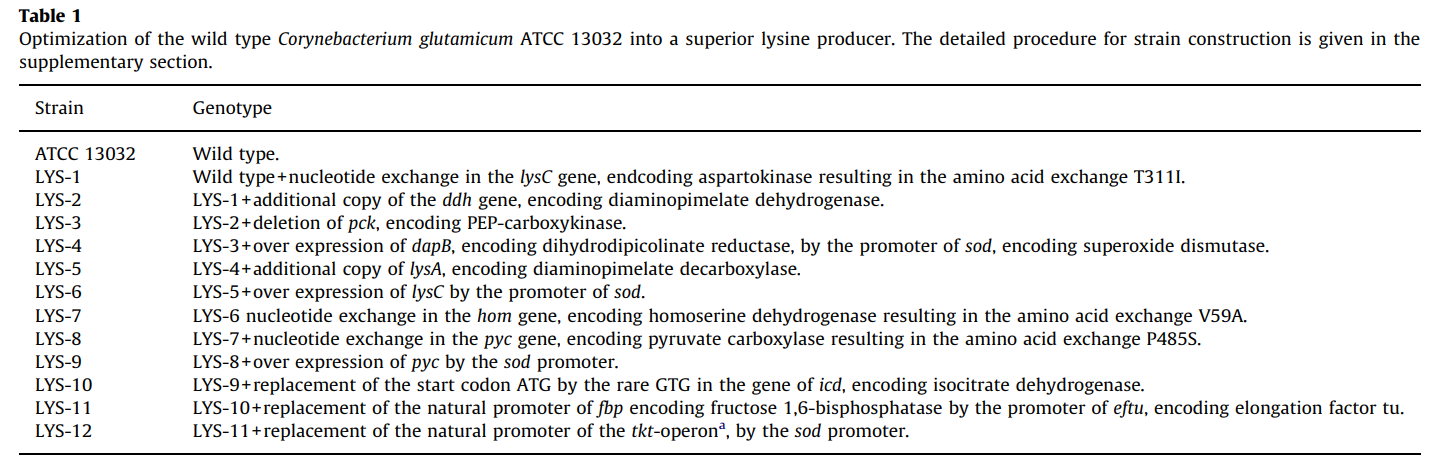

In [16]:
def getGeneName(full_gene_name_to_find):
    for gene_name, full_gene_name in genes.items():
        if full_gene_name_to_find == full_gene_name:
            return gene_name
    return None

def optimizeModel(model, mutant_name, full_gene_name=None, fold_change=None, knock_out_gene=False):

    printText("Mutant: ", Fore.BLACK, f"{mutant_name}", Fore.BLUE)

    new_model = model.copy()
    if fold_change is not None:
        arrow = "↑" if fold_change > 1 else "↓"

        printText(f"   Fold change of x{fold_change} for {getGeneName(full_gene_name)}: {arrow} {', '.join([rxn.id for rxn in model.genes.get_by_id(full_gene_name).reactions])}", Fore.CYAN, style=Style.NORMAL)
        
        for rxn in model.genes.get_by_id(full_gene_name).reactions:
            reaction = model.reactions.get_by_id(rxn.id)
            if reaction.lower_bound == 0:
                reaction.lower_bound = 0.01
            new_model.reactions.get_by_id(rxn.id).bounds = (fold_change * reaction.lower_bound, fold_change * reaction.upper_bound)

    if knock_out_gene:
        
        printText(f"   Knocking out {getGeneName(full_gene_name)}: {', '.join([rxn.id for rxn in model.genes.get_by_id(full_gene_name).reactions])}", Fore.RED, style=Style.NORMAL)
        new_model.genes.get_by_id(full_gene_name).knock_out()


    new_model.reactions.Growth.bounds = (0.259193805 , 1000)
    new_model.objective = new_model.reactions.DAPDC
    solution = new_model.optimize()

    print(f"Growth: {round(solution['Growth'], 6)} [1/h], lysine: {round(solution['DAPDC'], 6)} [mmol/gDW*h]")
    
    if round(solution['Growth'], 6) != 0.259194 or round(solution['DAPDC'], 6) != 6.397161:
        printText(f"(There is a new change!)", Fore.MAGENTA, style=Style.NORMAL)
        
    return new_model


| Mutant | Description from the paper | Our implementation in the model |
|-----------|-----------|-----------|
|   LYS1    |   a mutation releasing X coded by **lysC** from feedback inhibition    |   ↑ flux   |
|   LYS2    |   adding a second copy of **ddh** gene    |   the reaction coded by "ddh" (meso-diaminopimelate D-dehydrogenase: EC 1.4.1.16) doesn't exist in the model, it has be added |
|   LYS3    |   knockout of **pck**    |   knocking out **pck** |
|   LYS4    |   overexpression of X coded by **dapB**    |   ↑ flux |
|   LYS5    |   additional copy of X coded by **lysA**    |   ↑ flux |
|   LYS6    |   over expression of X coded by **lysC**    |   ↑ flux |
|   LYS7    |   leaky variant of X coded by **hom**    |   ↑ flux |
|   LYS8    |   imporoving  the activity of X coded by **pyc**    |   ↑ flux |
|   LYS9    |   imporoving  the activity of X coded by **pyc**    |   skipped (same as LYS8) |
|   LYS10    |   overexpression of FBPase coded by **fbp**     |   ↑ flux |
|   LYS11   |   overexpression  of X coded by **tkt**    |   ↑ flux |


In [17]:
LYS0 = optimizeModel(model, mutant_name="LYS0")

LYS1 = optimizeModel(LYS0, mutant_name="LYS1", full_gene_name=genes["lysC"], fold_change=1.25)

#LYS2 = optimizeModel(LYS1, mutant_name="LYS1", full_gene_name=genes["ddh"], fold_change=1.25)

LYS3 = optimizeModel(LYS1, mutant_name="LYS3", full_gene_name=genes["pck"], knock_out_gene=True) # LYS2 replaced by LYS1

LYS4 = optimizeModel(LYS3, mutant_name="LYS4", full_gene_name=genes["dapB"], fold_change=1.25)

LYS5 = optimizeModel(LYS4, mutant_name="LYS5", full_gene_name=genes["lysA"], fold_change=2.0)

LYS6 = optimizeModel(LYS5, mutant_name="LYS6", full_gene_name=genes["lysC"], fold_change=1.25)

LYS7 = optimizeModel(LYS6, mutant_name="LYS7", full_gene_name=genes["hom"], fold_change=1.25)

LYS8 = optimizeModel(LYS7, mutant_name="LYS8", full_gene_name=genes["pyc"], fold_change=1.25)

LYS9 = optimizeModel(LYS8, mutant_name="LYS9", full_gene_name=genes["pyc"], fold_change=1.25)

LYS10 = optimizeModel(LYS9, mutant_name="LYS10", full_gene_name=genes["fbp"], fold_change=1.25)

LYS11 = optimizeModel(LYS10, mutant_name="LYS11", full_gene_name=genes["tkt"], fold_change=1.25)



Mutant: LYS0
Growth: 0.259194 [1/h], lysine: 6.397161 [mmol/gDW*h]
Mutant: LYS1
   Fold change of x1.25 for lysC: ↑ ASPK
Growth: 0.259194 [1/h], lysine: 6.397161 [mmol/gDW*h]
Mutant: LYS3
   Knocking out pck: PEPCK_re, PPCK
Growth: 0.259194 [1/h], lysine: 6.397161 [mmol/gDW*h]
Mutant: LYS4
   Fold change of x1.25 for dapB: ↑ DHDPRy
Growth: 0.259194 [1/h], lysine: 6.397161 [mmol/gDW*h]
Mutant: LYS5
   Fold change of x2.0 for lysA: ↑ DAPDC
Growth: 0.259194 [1/h], lysine: 6.397161 [mmol/gDW*h]
Mutant: LYS6
   Fold change of x1.25 for lysC: ↑ ASPK
Growth: 0.259194 [1/h], lysine: 6.397161 [mmol/gDW*h]
Mutant: LYS7
   Fold change of x1.25 for hom: ↑ HSDx, HSDy
Growth: 0.259194 [1/h], lysine: 6.397161 [mmol/gDW*h]
Mutant: LYS8
   Fold change of x1.25 for pyc: ↑ PC
Growth: 0.259194 [1/h], lysine: 6.397161 [mmol/gDW*h]
Mutant: LYS9
   Fold change of x1.25 for pyc: ↑ PC
Growth: 0.259194 [1/h], lysine: 6.397161 [mmol/gDW*h]
Mutant: LYS10
   Fold change of x1.25 for fbp: ↑ FBP
Growth: 0.259194 [1/

## Conclusion:

**The implemented modifications didn't proivde any significant change or enhancement** for growth or lysine production.

In the mutant **LYS10**, there was the only change observed which is a slight decrease of lysine production after increasing the flux through **FBP** controlled by **fbp** gene.

As depicted in the figure below, **FBP** converts fructose 1,6-BP into fructose 6-p, thus working in opposite direction to glycolysis, and thus chanelling carbon away from both glycolysis and the TCA cycle toward the pentose phosphate pathway (PPP).

Given that oxaloacetate is the precusor of lysine within the TCA cycle, it can understood why increasing the flux of this enzyme has led to this small change.

It should be also noted that this analysis is mostly sensitive to the lower bond value **which was changed from 0 to 0.01** in order to allow for flux increase by multiplication with a factor.

**We acknowledge the intricate and indirect correlation between modifying genetic expression and the tangible enhancement of flux obtained from steady-state values in the model's solution**, but we took a simple approach of translating the genetic modifications from the paper in the case of overexpression by simply multiplying the flux with a factor.

The choice of increase the flux by **1.25** or **2.0** should be taken as an attempt **to exacerbate the modifcations implemented in the model and is not based on biological data**.


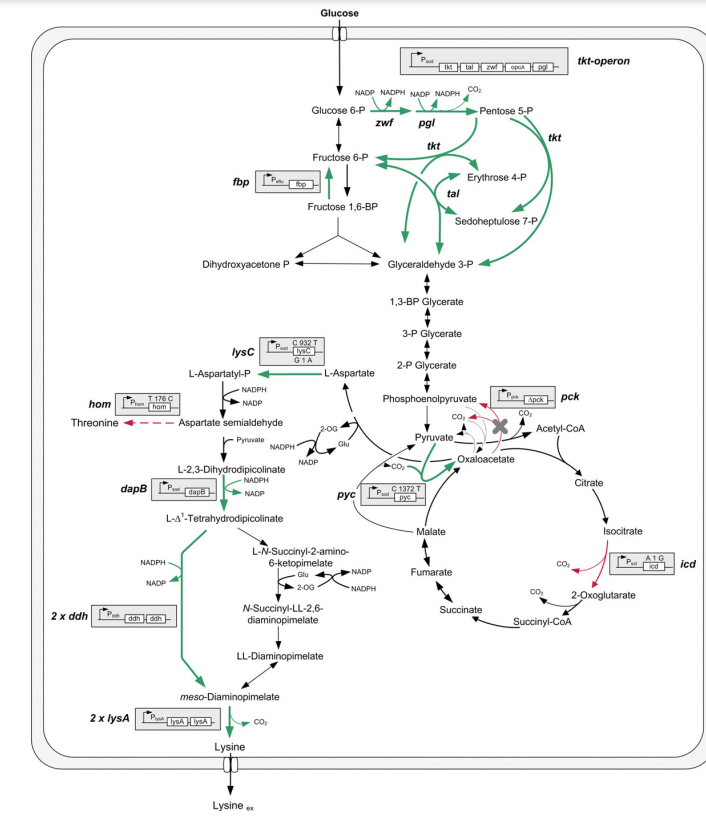

